In [2]:
# from google.colab import drive
# import os

# MOUNTPOINT = '/content/gdrive'
# DATADIR = os.path.join(MOUNTPOINT,'My Drive', 'AirQuality')
# drive.mount(MOUNTPOINT)

# dir_name = os.path.join(DATADIR, 'AQI prediction code/AQI_PM2.5/Results')

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime

# %pip install keras-tuner --upgrade
import keras_tuner
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def calculate_smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.show()


def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[(i+look_back), 0])
    return np.array(X), np.array(Y)


def build_model(hp, train_shape, look_back):
    model = Sequential()
    #  if hp is passed then tune hyperparameters
    if hp:
        model.add(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=366, step=32), return_sequences=False, input_shape=(look_back, 1)))
        model.add(Dense(1))
        hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=hp_learning_rate), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    else:
        # return_sequences = True for stacked LSTM, where last LSTM layer must have return_sequences = False!
        model.add(LSTM(units=100, return_sequences=False, input_shape=(look_back, 1)))
        model.add(Dense(1))
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

def split_data(df, offset, train_size, test_size):
    train_data = df.loc[df.index.min() + pd.DateOffset(days=offset) : df.index.min() + pd.DateOffset(days=offset) + pd.DateOffset(months=train_size)]

    # If there is no number_of_test_values left in the df to the end, then train and test should be none
    if train_data.index.max() + pd.DateOffset(days=test_size) > df.index.max():
        return None, None, None, None, None, None

    test_data = df.loc[train_data.index.max() + pd.DateOffset(days=1) : train_data.index.max() + pd.DateOffset(days=test_size)]

    start_date, slice_date, end_date = train_data.index.min(), train_data.index.max(), test_data.index.max()

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    return train_data, test_data, scaler, start_date, slice_date, end_date

def train_LSTM_model(train_data, look_back, batch_size, epochs, tune_hyperparameters):
    # Prepare input and output for LSTM model
    x_train, y_train = create_dataset(train_data, look_back)

    # LSTM expects inputs to be shaped as (batch_size, timesteps, channels) or (num_samples, timesteps, features)
    x_train = np.reshape(x_train, (x_train.shape[0], look_back, 1))

    # Splitting the last val_size of data for validation
    val_size = int(0.1 * len(x_train))
    x_train, y_train = x_train[:-val_size], y_train[:-val_size]
    x_val, y_val = x_train[-val_size:], y_train[-val_size:]

    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    if tune_hyperparameters:
        # Training the model
        tuner = keras_tuner.Hyperband(
                            # must be wrapped in lambda because build_model() takes more than hp as argument
                            hypermodel=lambda hp: build_model(hp, x_train.shape[0], look_back),
                            objective=[keras_tuner.Objective("val_loss", "min")],
                            max_epochs=10,
                            overwrite=True,
                            project_name='LSTM_hyperparameter_tuning'
                            )
        tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop])
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        print("\nBest hyperparameters: \n")
        print(best_hps.values)

        model = tuner.hypermodel.build(best_hps)
    else:
        model = build_model(hp=None, train_shape=x_train.shape[0], look_back=look_back)

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                        validation_data=(x_val, y_val), callbacks=[early_stop])


    return model, history

def test_LSTM_model(model, train_data, test_data, look_back, scaler):
    # Testing the model using sequential predictions
    # making test set: x_test[0] = x_train[-5:]; x_test[1] = x_train[-4:],x_test[0]; x_test[2] = x_train[-3:],x_test[0],x_test[1] and so on
    x_test = train_data[-look_back:]
    y_test = test_data
    testPredict = []

    for i in range(0, len(test_data)):
        x_test, y_test = np.array(x_test), np.array(y_test)
        x_test = np.reshape(x_test, (1, look_back, 1))
        y_pred = model.predict(x_test, verbose=0)
        # append y_pred value to testPredict
        testPredict.append(y_pred[0][0])
        # push the predictions to the end of the test set so it pushes out first value
        x_test = np.append(x_test, y_pred[0][0])
        # x_test = np.append(x_test, y_test[i][0])
        x_test = x_test[1:]

    testPredict = np.reshape(testPredict, (-1,1))
    testPredict = scaler.inverse_transform(testPredict)
    y_test = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test, testPredict)
    rmse = np.sqrt(mean_squared_error(y_test, testPredict))
    r2 = r2_score(y_test, testPredict)
    smape = calculate_smape(y_test, testPredict)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 Score:", r2)
    print("SMAPE:", smape)

    return rmse, mae, r2, smape, testPredict, y_test

In [4]:
# Write experiment data to file
dir_name = 'Results' #locally
file_name = 'LSTM_experiment_results.csv'
results_file_path = os.path.join(dir_name, file_name)

# Create the directory if it doesn't exist
os.makedirs(dir_name, exist_ok=True)

# Experiment parameters
tune_hyperparameters = False
epochs = 10

# train_size represents the number of months to be used for training (e.g. 4*12 is 4 years, 6 is 0.5 years)
# test_sizes represents the number of days to be used for testing (e.g. 4*7 is 4 weeks)
experiment_cases = [
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},

    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]}
]

# *All experiment results have been written to file, comment out the following lines only if you want to re-run the experiments
# for experiment_case in experiment_cases:
#     #input_dir = experiment_case['input_dir'] #locally
#     input_dir = "/content/gdrive/MyDrive/AirQuality/AQI prediction code/AQI_PM2.5/Dataset"
#     filename = experiment_case['filename']
#     label = experiment_case['label']
#     train_size = experiment_case['train_size']
#     test_sizes = experiment_case['test_sizes']

#     if 'hourly' in filename:
#         look_back = 5
#         batch_size = 128
#     if 'daily' in filename:
#         look_back = 3
#         batch_size = 30

#     # Load the CSV file
#     df = pd.read_csv(os.path.join(input_dir,filename))
#     df.DateTime = pd.to_datetime(df.DateTime)
#     df = df.set_index('DateTime')

#     print(f'\nRunning experiment for {filename} with label {label}:\n')
#     for test_size in test_sizes:
#         offset = 0 # start from the beginning of the dataframe
#         while True:
#             train_data, test_data, scaler, start_date, slice_date, end_date = split_data(df, offset, train_size, test_size)

#             if train_data is None or test_data is None:
#                 print(f'No more data for test size {test_size} days')
#                 break

#             offset += 7 # move train+test window forward by 7 days for next iteration

#             # if start_date == pd.to_datetime('2020-04-21 17:00:00'):
#             #     print(f'Offset = {offset}')
#             #     break

#             model, history = train_LSTM_model(train_data, look_back, batch_size, epochs, tune_hyperparameters)

#             rmse, mae, r2, smape, testPredict, y_test = test_LSTM_model(model, train_data, test_data, look_back, scaler)

#             # Prepare data for CSV
#             data = {
#                 'DateTime of experiment': [datetime.datetime.now()],
#                 'Dataset used': [filename],
#                 'Label predicted': [label],
#                 'Training data from': [start_date],
#                 'Training data to': [slice_date],
#                 'Testing data from': [slice_date],
#                 'Testing data to': [end_date],
#                 'Test size': [len(test_data)],
#                 'look_back': [look_back],
#                 'batch_size': [batch_size],
#                 'epochs': [epochs],
#                 # 'Model configuration': [json.dumps(model.get_config())],
#                 'Test Predictions': [testPredict.tolist()],
#                 'Test Data': [y_test.tolist()],
#                 'RMSE': [rmse],
#                 'MAE': [mae],
#                 'R2': [r2],
#                 'SMAPE': [smape]
#             }

#             # print finished iteration
#             print(f'Finished iteration offset={offset} days train_size={train_size} months test_size={test_size} days\n')

#             # Convert to DataFrame
#             df_result = pd.DataFrame(data)

#             # Write DataFrame to CSV
#             df_result.to_csv(results_file_path, mode='a', header=not os.path.exists(results_file_path), index=False)


Results for dataset_aqi_daily.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 22.014552906799786
RMSE: 33.41058200759049
R2: 0.43182522238530263
SMAPE: 26.039092279857844
Errors for 7 days:
MAE: 37.06035892675954
RMSE: 45.15948491396169
R2: 0.1151295531543759
SMAPE: 45.14253133662736
Errors for 14 days:
MAE: 39.507132591085224
RMSE: 48.298613885968095
R2: -0.021180501299718824
SMAPE: 47.42619643474351
Errors for 28 days:
MAE: 42.33047966923274
RMSE: 49.88181900772463
R2: -0.07144293382364109
SMAPE: 50.95194944914108


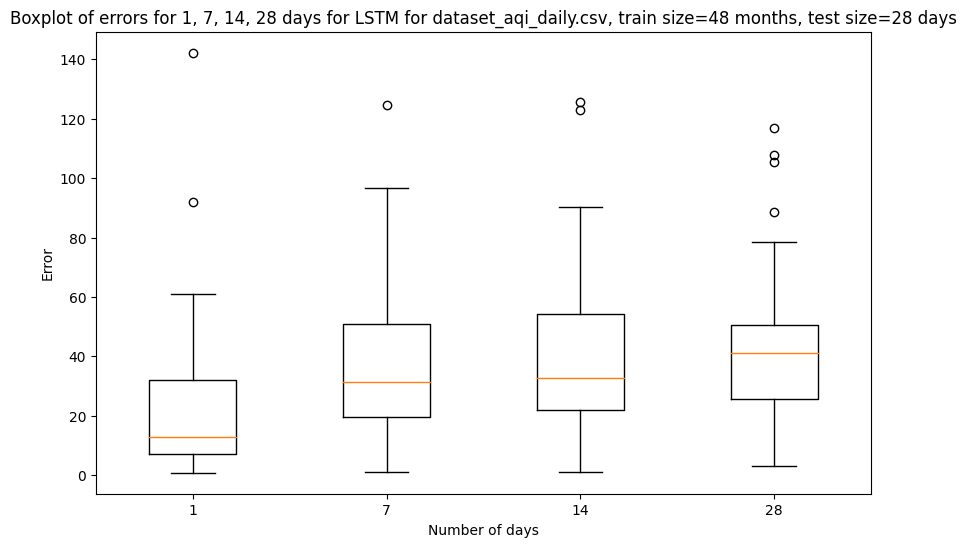


Results for dataset_aqi_hourly.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 33.38097585584116
RMSE: 44.72091565284177
R2: 0.2945900917780566
SMAPE: 41.467807203868254
Errors for 7 days:
MAE: 84.03948736426379
RMSE: 162.0413855161682
R2: -9.576442100936317
SMAPE: 66.0235551977691
Errors for 14 days:
MAE: 84.80996850812963
RMSE: 162.9719366337922
R2: -9.591815722361973
SMAPE: 67.61211516987106
Errors for 28 days:
MAE: 84.68207765132823
RMSE: 163.24620068049347
R2: -9.714339448743843
SMAPE: 70.93344135274164


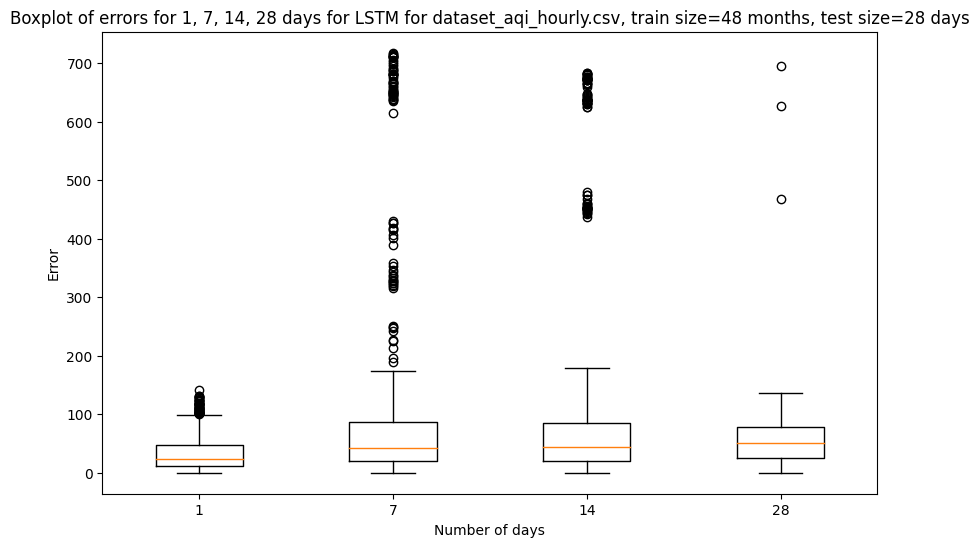


Results for dataset_aqi_daily_filled_with_neighbors.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 23.86544139578576
RMSE: 36.41010616749735
R2: 0.32522690294895906
SMAPE: 27.45945762886146
Errors for 7 days:
MAE: 36.17708777028618
RMSE: 44.693467772332276
R2: 0.13329792358697867
SMAPE: 44.44093752962559
Errors for 14 days:
MAE: 36.927708808411936
RMSE: 47.7516910178361
R2: 0.0018158010371759348
SMAPE: 44.327008932603114
Errors for 28 days:
MAE: 39.2324004207097
RMSE: 47.88682997682026
R2: 0.012546490901312768
SMAPE: 47.6359558043709


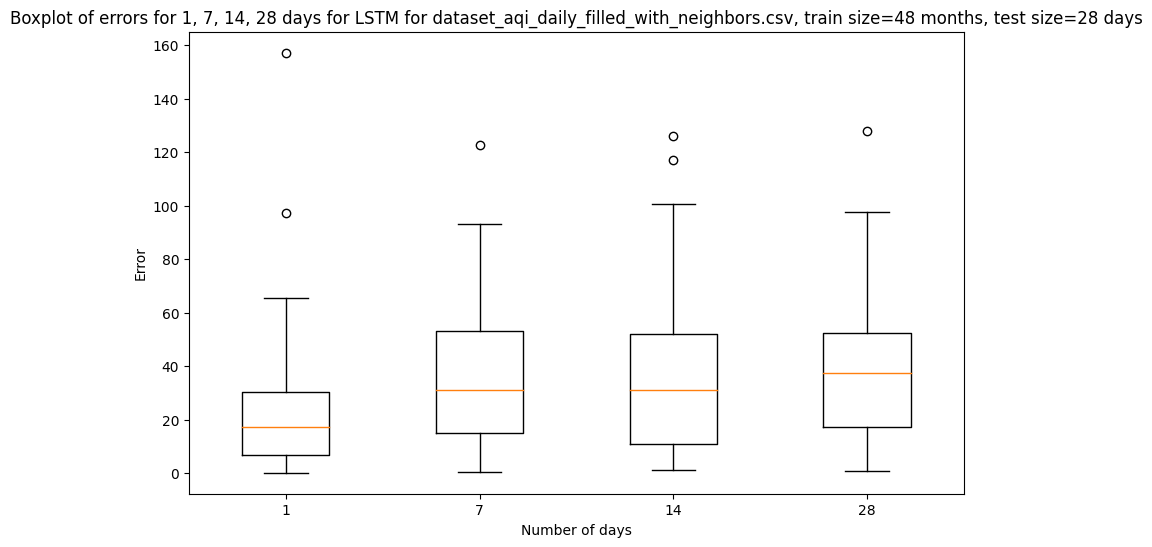


Results for dataset_aqi_hourly_filled_with_neighbors.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 32.693668556551565
RMSE: 42.42733118758717
R2: 0.3705756216181817
SMAPE: 40.82274216834941
Errors for 7 days:
MAE: 138.3788015470437
RMSE: 223.11498572750406
R2: -18.95958693638946
SMAPE: 81.37050121281302
Errors for 14 days:
MAE: 155.42058765803668
RMSE: 250.08012940885155
R2: -23.828407687985656
SMAPE: 83.1104113427909
Errors for 28 days:
MAE: 167.15837429939432
RMSE: 267.0245301967743
R2: -27.666954410004852
SMAPE: 91.33305161790514


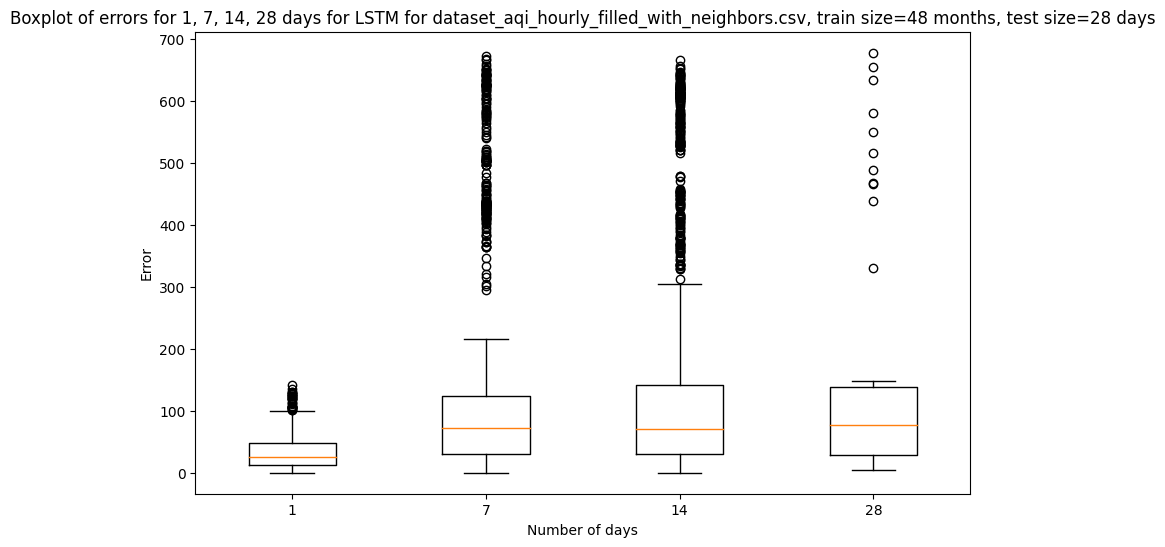


Results for dataset_aqi_daily.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 32.78047476928563
RMSE: 45.44911963732455
R2: 0.3004346642576249
SMAPE: 37.366114373917945
Errors for 7 days:
MAE: 43.561468445972906
RMSE: 55.02092140440005
R2: -0.148032554552457
SMAPE: 49.730391049894735
Errors for 14 days:
MAE: 44.99765209953093
RMSE: 56.57135158890648
R2: -0.21240155815033135
SMAPE: 51.26808881354385
Errors for 28 days:
MAE: 43.66848012556778
RMSE: 55.0645255394722
R2: -0.1473974380907892
SMAPE: 49.910401350692375


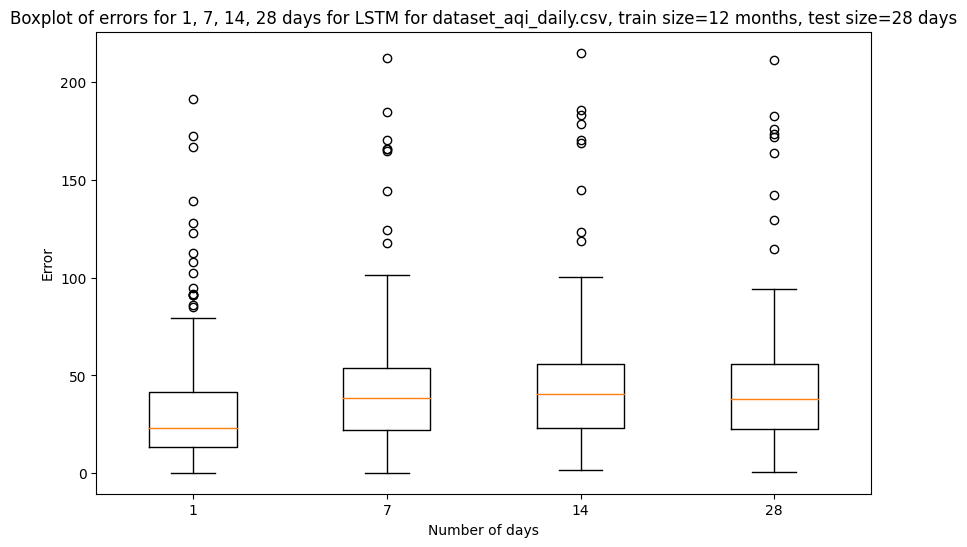


Results for dataset_aqi_hourly.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 35.9704188409837
RMSE: 50.062140639978715
R2: 0.33205867823980595
SMAPE: 44.122852805134535
Errors for 7 days:
MAE: 73.52948355983571
RMSE: 105.02598438061295
R2: -2.1566234123231705
SMAPE: 68.00503233613756
Errors for 14 days:
MAE: 82.36055171729303
RMSE: 131.0771604382409
R2: -3.9179192304582564
SMAPE: 65.87608747097002
Errors for 28 days:
MAE: 90.24038460258153
RMSE: 150.593033413974
R2: -5.93465782543908
SMAPE: 71.32054865696053


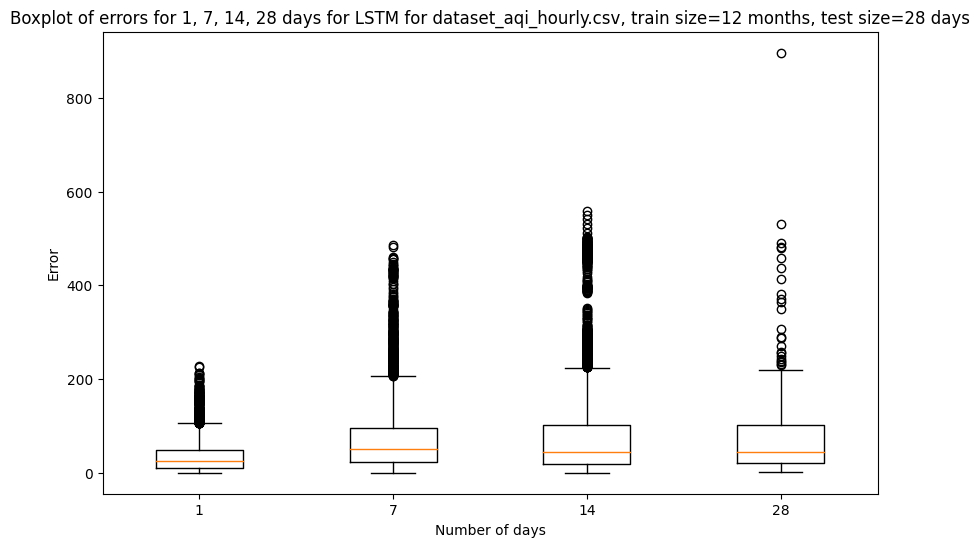


Results for dataset_aqi_daily_filled_with_neighbors.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 33.32163237464807
RMSE: 45.56024971119138
R2: 0.2966912655505972
SMAPE: 38.15455459010897
Errors for 7 days:
MAE: 44.11000163732076
RMSE: 55.375105681541925
R2: -0.1625620058023074
SMAPE: 50.340486053512144
Errors for 14 days:
MAE: 45.9731939758225
RMSE: 56.74796633085278
R2: -0.21967036696630893
SMAPE: 52.33476134438788
Errors for 28 days:
MAE: 44.605315666490775
RMSE: 55.821905847764775
R2: -0.17930608157793104
SMAPE: 50.87356563941225


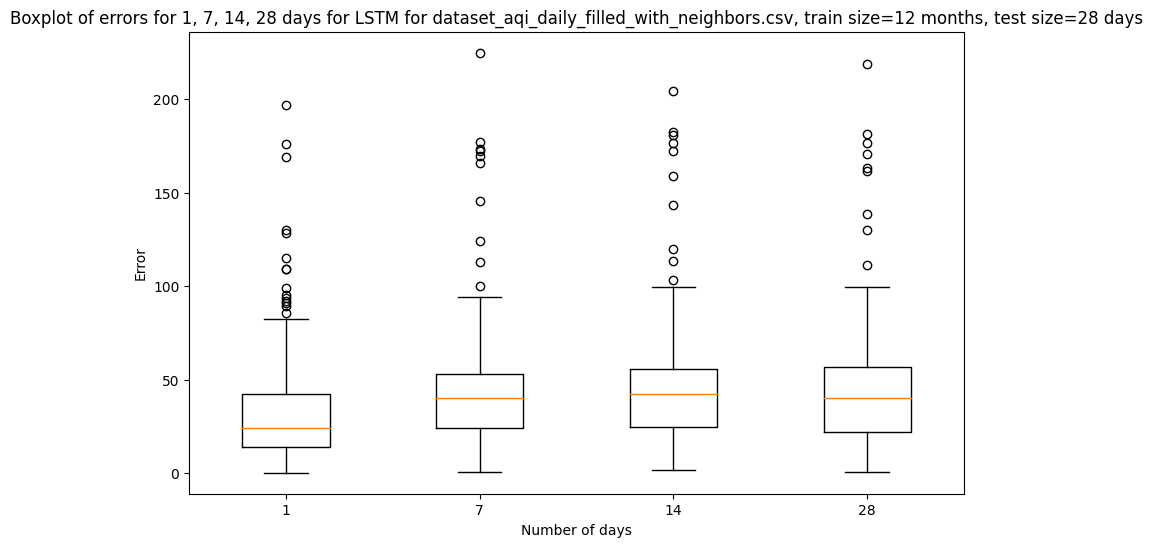


Results for dataset_aqi_hourly_filled_with_neighbors.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 37.76372668794906
RMSE: 64.13325094589321
R2: -0.09260484349653608
SMAPE: 43.975622711771884
Errors for 7 days:
MAE: 89.38277721071329
RMSE: 278.51248370591384
R2: -21.12156605301389
SMAPE: 65.67383325171207
Errors for 14 days:
MAE: 111.34244864300403
RMSE: 420.2885668505292
R2: -49.38735316360976
SMAPE: 65.67134368417697
Errors for 28 days:
MAE: 119.1781580085022
RMSE: 458.2864992353336
R2: -60.57581903242365
SMAPE: 70.17997430907911


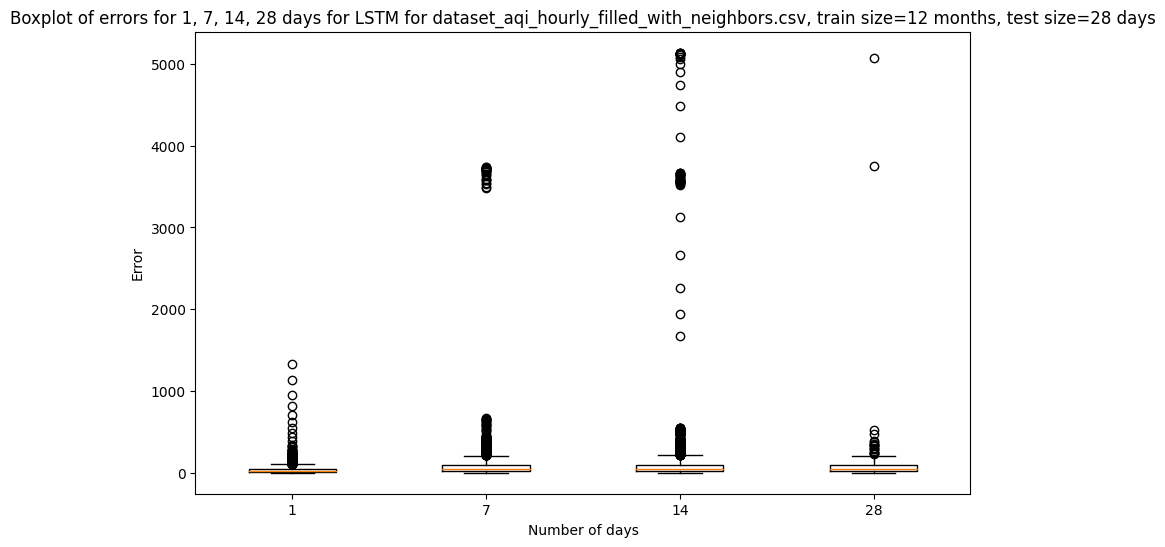


Results for dataset_aqi_daily.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 38.195519368808796
RMSE: 52.27913508524733
R2: 0.17750227250464723
SMAPE: 41.68486795754944
Errors for 7 days:
MAE: 54.993307698325054
RMSE: 68.37344982572358
R2: -0.6414022497063567
SMAPE: 57.347195952310116
Errors for 14 days:
MAE: 61.97553307811479
RMSE: 75.74293011523622
R2: -0.847970619128674
SMAPE: 63.735289291810325
Errors for 28 days:
MAE: 64.66614763372125
RMSE: 79.42665952650798
R2: -1.0039294877755873
SMAPE: 66.00871014926685


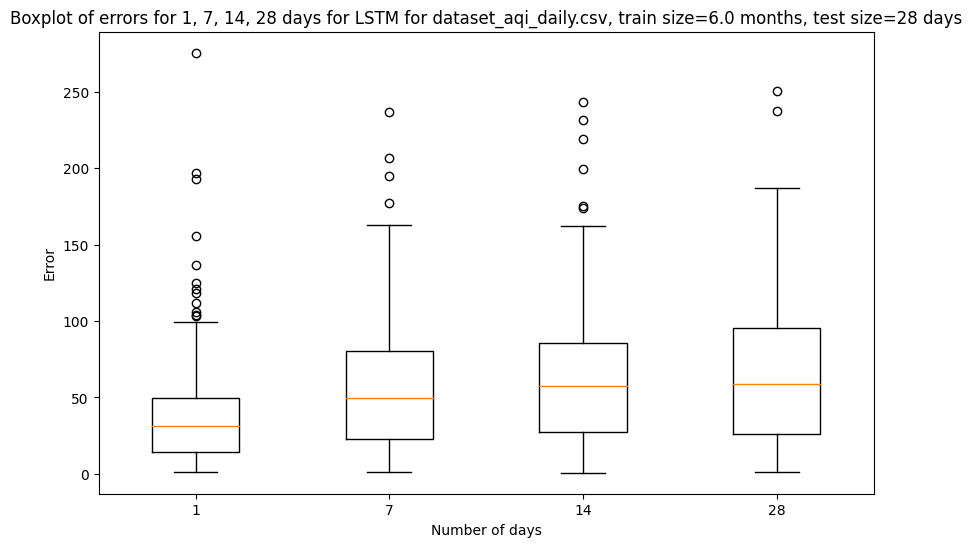


Results for dataset_aqi_hourly.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 39.651620385919
RMSE: 60.371313985215345
R2: 0.2689870476006977
SMAPE: 43.903841691649326
Errors for 7 days:
MAE: 61.75218725644562
RMSE: 139.81298981056278
R2: -4.272505466535269
SMAPE: 61.04750326156878
Errors for 14 days:
MAE: 76.00990986182113
RMSE: 204.1284930866754
R2: -11.096526464334017
SMAPE: 64.04120111820886
Errors for 28 days:
MAE: 85.94914812814667
RMSE: 239.11943917794696
R2: -14.125611219917108
SMAPE: 70.32892243635972


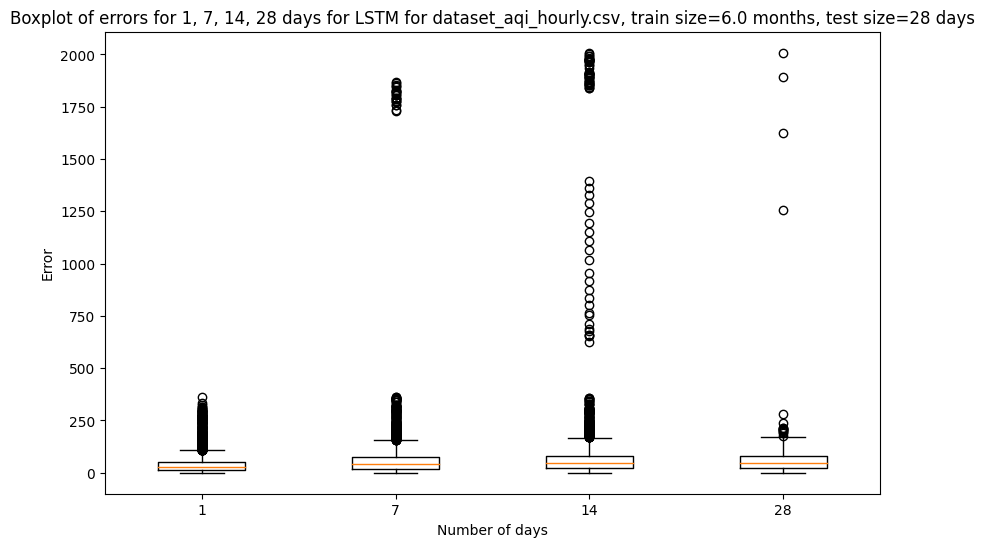


Results for dataset_aqi_daily_filled_with_neighbors.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 38.59784224250036
RMSE: 52.78580331103188
R2: 0.15640234095629446
SMAPE: 41.75906392956465
Errors for 7 days:
MAE: 55.419529848392315
RMSE: 68.78464676989566
R2: -0.672325908195518
SMAPE: 57.21289728245727
Errors for 14 days:
MAE: 61.46797989358886
RMSE: 75.27143062967617
R2: -0.8364488540246147
SMAPE: 62.74582178694225
Errors for 28 days:
MAE: 64.7286272979976
RMSE: 79.30767981994302
R2: -1.0083742482317755
SMAPE: 65.82197939918275


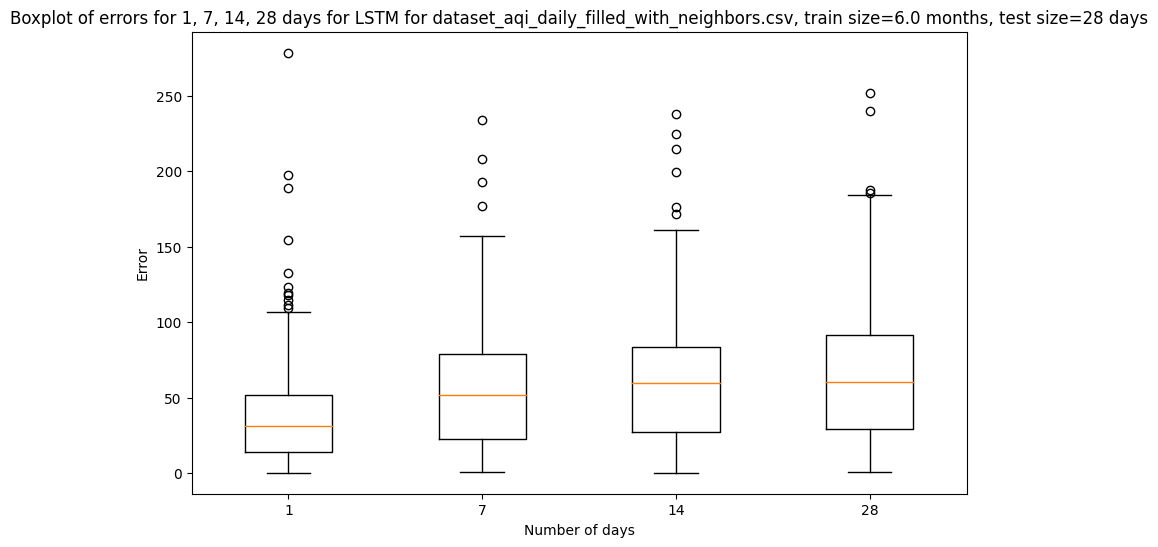


Results for dataset_aqi_hourly_filled_with_neighbors.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 39.40566467829293
RMSE: 60.773545403811404
R2: 0.2583559573954991
SMAPE: 43.26675972372969
Errors for 7 days:
MAE: 80.46407209709875
RMSE: 336.89076454401544
R2: -29.63110506553162
SMAPE: 61.506652706172986
Errors for 14 days:
MAE: 97.18621693369876
RMSE: 390.7567141390496
R2: -43.40229075087226
SMAPE: 62.373294401032105
Errors for 28 days:
MAE: 104.15778033049646
RMSE: 398.3181499026223
R2: -39.521822371480134
SMAPE: 68.51896427100311


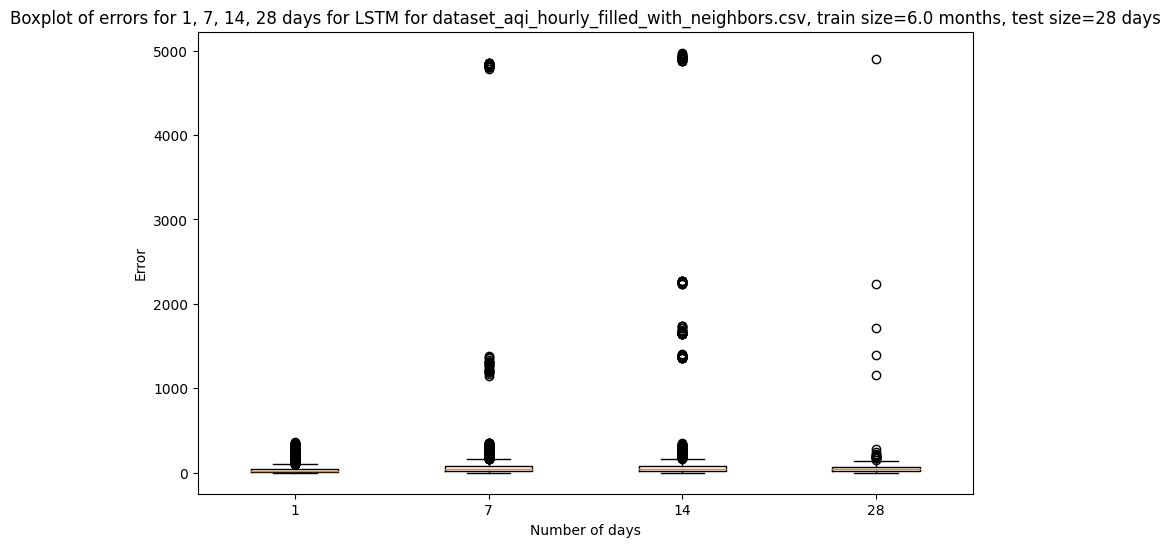

In [5]:
df_results = pd.read_csv(results_file_path)

# convert to datetime
df_results['DateTime of experiment'] = pd.to_datetime(df_results['DateTime of experiment'])
df_results['Training data from'] = pd.to_datetime(df_results['Training data from'])
df_results['Training data to'] = pd.to_datetime(df_results['Training data to'])
df_results['Testing data from'] = pd.to_datetime(df_results['Testing data from'])
df_results['Testing data to'] = pd.to_datetime(df_results['Testing data to'])
# convert Test Data and Test Predictions to lists of doubles
df_results['Test Data'] = df_results['Test Data'].apply(lambda x: [item[0] for item in json.loads(x)])
df_results['Test Predictions'] = df_results['Test Predictions'].apply(lambda x: [item[0] for item in json.loads(x)])
# calculate time delta in months round to 0 decimals
df_results['Training Duration'] = ((df_results['Training data to'] - df_results['Training data from']) / np.timedelta64(1, 'M')).round(0).astype(int)
df_results['Testing duration'] = ((df_results['Testing data to'] - df_results['Testing data from']) / np.timedelta64(1, 'D')).round(0).astype(int)

for experiment_case in experiment_cases:
    filename = experiment_case['filename']
    label = experiment_case['label']
    train_size = experiment_case['train_size']
    test_sizes = experiment_case['test_sizes']

    print(f'\nResults for {filename} with label {label}, train_size={train_size} months, test_size={test_sizes[0]} days:\n')

    df_results_filtered = df_results[(df_results['Dataset used'] == filename) & (df_results['Label predicted'] == label) & (df_results['Training Duration'] == train_size) & (df_results['Testing duration'] == test_sizes[0])]

    # Columns that contain list of predictions for each experiment
    tests_column = df_results_filtered['Test Data']
    predictions_column = df_results_filtered['Test Predictions']

    test_data_for_periods = []
    prediction_data_for_periods = []

    # Calculating errors for 1, 7, 14, 28 days and plotting forecast plot and boxplot
    for i in [1, 7, 14, 28]:
        # take i-1-th (-1 because enumerations starts from 0) element from each list of tests and predictions columns
        if 'daily' in filename:
            tests = tests_column.apply(lambda x: x[i-1])
            predictions = predictions_column.apply(lambda x: x[i-1])
        elif 'hourly' in filename:
            tests = pd.Series([item for sublist in tests_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])
            predictions = pd.Series([item for sublist in predictions_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])

        test_data_for_periods.append(tests)
        prediction_data_for_periods.append(predictions)

        # Calculate errors
        mae = mean_absolute_error(tests, predictions)
        rmse = np.sqrt(mean_squared_error(tests, predictions))
        r2 = r2_score(tests, predictions)
        smape = calculate_smape(tests, predictions)

        print(f'Errors for {i} days:')
        print(f'MAE: {mae}')
        print(f'RMSE: {rmse}')
        print(f'R2: {r2}')
        print(f'SMAPE: {smape}')

    # Plot boxplot of errors as error = abs(predictions - tests) for 1, 7, 14, 28 days on one plot where x label shows number of days
    plt.figure(figsize=(10,6))
    plt.boxplot([abs(test_data_for_periods[0] - prediction_data_for_periods[0]), abs(test_data_for_periods[1] - prediction_data_for_periods[1]), abs(test_data_for_periods[2] - prediction_data_for_periods[2]), abs(test_data_for_periods[3] - prediction_data_for_periods[3])])
    plt.xticks([1, 2, 3, 4], [1, 7, 14, 28])
    plt.xlabel('Number of days')
    plt.ylabel('Error')
    plt.title(f'Boxplot of errors for 1, 7, 14, 28 days for LSTM for {filename}, train size={train_size} months, test size={test_sizes[0]} days')
    plt.show()